<a href="https://colab.research.google.com/github/CIumsy/ML-Drift-Detection/blob/main/ML_Drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: ML Monitoring with NannyML

In this tutorial, we will utilize the [Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)
 to build a machine-learning model that predicts customer churn. After training the model, we will implement NannyML to monitor its performance on unseen data and identify potential reasons for any performance declines through data drift detection methods. This approach will help us better understand customer retention and improve service strategies.

## Setting up
The following cell will import the necessary libraries plus install NannyML. NannyML is an open-source library to do post-deployment data science. We will use it to estimate the model's performance with unseen data and run multivariate and univariate drift tests.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, plot_importance

%pip install nannyml
import nannyml as nml

## Getting the data

We will be using the following columns from the Telco Customer Churn dataset:


*   gender: Gender of the customer.
*   SeniorCitizen: Indicates if the customer is a senior citizen (1 for yes, 0
    for no).
*   tenure: Number of months the customer has stayed with the company.
*   MonthlyCharges: Monthly charges for the customer.
*   TotalCharges: Total charges incurred by the customer.
*   InternetService: Type of internet service (DSL/Fiber optic/No).
*   Contract: Type of contract (Month-to-month, One year, Two year).
*   Churn: Indicates if the customer has churned (Yes/No). This column will be  
    the target variable.

Other columns were omitted due to high missing values, low variance, or because they are not directly relevant to predicting churn.

In [76]:
# Read data from URL
url = "https://raw.githubusercontent.com/CIumsy/customer-churn-analysis/refs/heads/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
columns = ['gender', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'Contract', 'Churn']
data = pd.read_csv(url, usecols=columns)

In [77]:
data.head()

,gender,SeniorCitizen,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,DSL,Month-to-month,29.85,29.85,No
1,Male,0,34,DSL,One year,56.95,1889.5,No
2,Male,0,2,DSL,Month-to-month,53.85,108.15,Yes
3,Male,0,45,DSL,One year,42.30,1840.75,No
4,Female,0,2,Fiber optic,Month-to-month,70.70,151.65,Yes


## Preprocessing the data

Before modeling, we will perform the following preprocessing steps:

1. **Filter Relevant Contracts:** We will focus on specific contract types, excluding customers on "Month-to-month" contracts to streamline our analysis.

2. **Handle Missing Values:** Any rows with missing values in critical columns like TotalCharges and MonthlyCharges will be removed to ensure data quality.

3. **Convert Data Types:** We will ensure that the TotalCharges column is in the correct numeric format for analysis.

4. **Create Target Variable:** A binary target variable will be generated from the Churn column, with "Yes" mapped to 1 and "No" mapped to 0.

5. **Encode Categorical Variables:** Categorical columns like gender, InternetService, and Contract will be converted into numerical representations through one-hot encoding.

6. **Sort Data:** The dataset will be sorted by the tenure column to assist in future analysis and model training.



In [78]:
# Read data from the raw URL
url = "https://raw.githubusercontent.com/CIumsy/customer-churn-analysis/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
columns = ['gender', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService', 'Contract', 'Churn']
data = pd.read_csv(url, usecols=columns)

# Handle missing values: Remove rows with missing TotalCharges and MonthlyCharges
data = data.dropna(subset=['TotalCharges', 'MonthlyCharges'])

# Convert TotalCharges to numeric (if it's not already)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Further drop rows where TotalCharges could not be converted
data = data.dropna(subset=['TotalCharges'])

# Create target variable
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Encode categorical variables using mapping
data['gender'] = data['gender'].map({'Female': 0, 'Male': 1})
data['InternetService'] = data['InternetService'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
data['Contract'] = data['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# Sort data by tenure
data = data.sort_values('tenure').reset_index(drop=True)

In [79]:
data.head()

,gender,SeniorCitizen,tenure,InternetService,Contract,MonthlyCharges,TotalCharges,Churn
0,0,0,1,1,0,29.85,29.85,0
1,0,0,1,2,0,74.50,74.50,1
2,0,0,1,1,0,40.10,40.10,1
3,1,1,1,2,0,76.45,76.45,1
4,0,1,1,2,0,79.20,79.20,1


Now, we will split the dataset into three distinct subsets: training, testing, and production. This approach is crucial for developing a robust machine learning model.


* Train Set: This will comprise 80% of the data, which will be used to train  
  the model. The model will learn the underlying patterns related to customer churn based on the features provided.

* Test Set: 10% of the data will be set aside for testing the model's     
  performance. This set will provide insights into how well the model   
  generalizes to unseen data, which is essential for assessing its accuracy and reliability.
  
* Production Set: The remaining 10% of the data will simulate a production
  environment. This dataset will help us understand how the model performs with real-world data, allowing us to monitor its effectiveness and detect any potential drift over time.

This method of splitting the dataset is fundamental for ensuring that our model is not only effective in training but also capable of maintaining performance in practical applications.

In [80]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'Churn' is the target variable
x = data.drop(columns='Churn')  # Features (input variables)
y = data['Churn']               # Target variable

# Step 1: Split data into train and temp sets (80% for train, 20% for test + production)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Further split the temp set into test and production sets (50% test, 50% production)
x_test, x_prod, y_test, y_prod = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Now you have the following:
# x_train, y_train: for training
# x_test, y_test: for testing (evaluation)
# x_prod, y_prod: simulate production data (no target in real production data)


## Exploring the training data

Let's quickly explore the training data to ensure we understand it and check that everything makes sense. Since we are building a model that can predict customer churn, it's essential to examine the distribution of the target variable, Churn.

The table below provides an overview of the key statistics for the Churn column. We will look at the distribution of values to understand the balance between classes (i.e., customers who churned vs. those who did not). This will help us identify if there are any imbalances that could affect our model's performance.

Next, we can visualize the distribution using a bar plot to gain insights into how many customers churned compared to those who did not.

In [81]:
churn_counts = y_train.value_counts()
print(churn_counts)

0    4130
1    1495
Name: Churn, dtype: int64


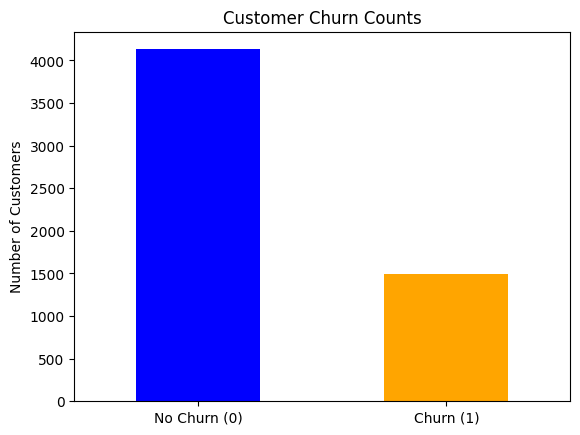

In [82]:
import matplotlib.pyplot as plt

churn_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Customer Churn Counts')
plt.xticks(ticks=[0, 1], labels=['No Churn (0)', 'Churn (1)'], rotation=0)
plt.ylabel('Number of Customers')
plt.show()


## Training a model

In [83]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Fit the model
model = LGBMClassifier(random_state=111)  # Change to LGBMClassifier
model.fit(x_train, y_train)

LGBMClassifier(random_state=111)

Once the model is trained, we make predictions on the train and test data to evaluate it.

In [84]:
# Make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

## Evaluating the model

Since churn is a binary classification problem, we can create a baseline model that always predicts the majority class in the training set.

In [85]:
# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mode()[0]  # Use mode for binary classification
y_pred_test_baseline = np.ones_like(y_test) * y_train.mode()[0]    # Same for test

We can evaluate our model's performance using accuracy instead of Mean Absolute Error since we're dealing with a classification problem.

In [86]:
from sklearn.metrics import accuracy_score

# Measure train and test performance
accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)

# Measure baseline performance
accuracy_train_baseline = round(accuracy_score(y_train, y_pred_train_baseline), 4)
accuracy_test_baseline = round(accuracy_score(y_test, y_pred_test_baseline), 4)

# Print results
print(f"Train Accuracy: {accuracy_train}, Baseline Train Accuracy: {accuracy_train_baseline}")
print(f"Test Accuracy: {accuracy_test}, Baseline Test Accuracy: {accuracy_test_baseline}")

Train Accuracy: 0.851, Baseline Train Accuracy: 0.7342
Test Accuracy: 0.7866, Baseline Test Accuracy: 0.734


**Confusion Matrix**:
This gives a detailed breakdown of how well our model is classifying the churn and non-churn classes. It's particularly useful for understanding the types of errors our model is making.


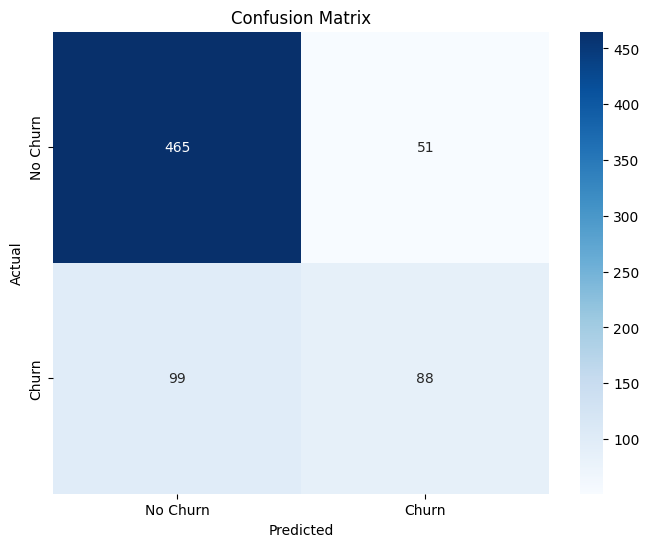

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**ROC Curve:**
This shows the model's ability to distinguish between classes across different threshold values. It's great for assessing the trade-offs between true positive and false positive rates.

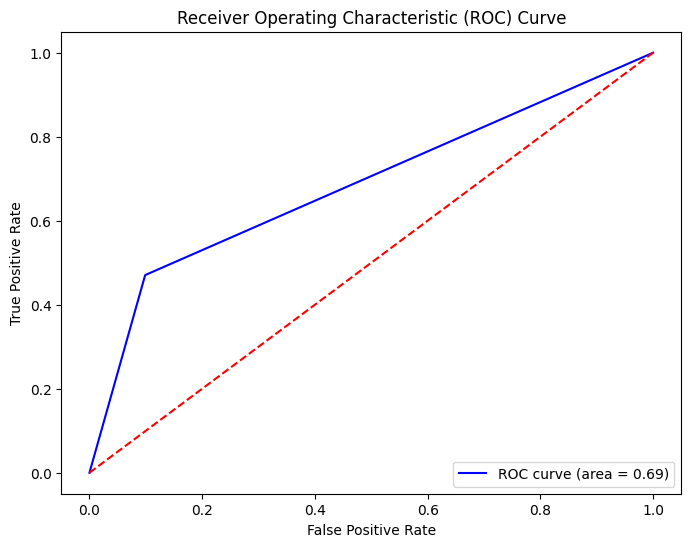

In [88]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Bar Plot of Accuracy Metrics:**
This offers a straightforward comparison of our model's accuracy against a baseline, making it easy to see the improvements.

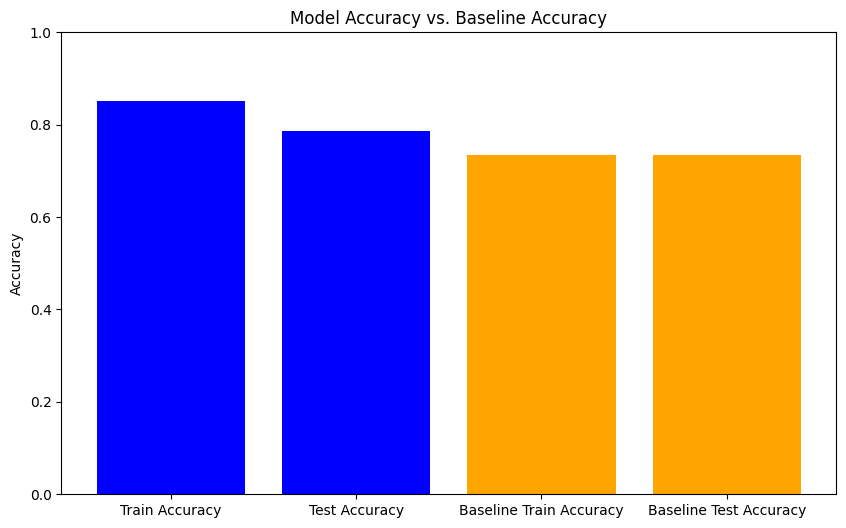

In [89]:
import numpy as np

# Define labels and values
labels = ['Train Accuracy', 'Test Accuracy', 'Baseline Train Accuracy', 'Baseline Test Accuracy']
values = [accuracy_train, accuracy_test, accuracy_train_baseline, accuracy_test_baseline]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'blue', 'orange', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to [0, 1]
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Baseline Accuracy')
plt.show()

## Deploying the model

To simulate that we are in a production environment, we will use the trained model to make predictions on unseen production data.

We will later use NannyML to check how well the model performs on this data.

In [90]:
y_pred_prod = model.predict(x_prod)

## Analysing ML model performance in production

* **Reference Dataset:**
Since there's no date column, we just include the features, the model’s predictions, and the actual churn labels.

* **Analysis Dataset:**
For the analysis dataset, we only include the features and the model’s predictions, as we don't know the actual churn outcomes yet in production.

In [91]:
# Get predicted probabilities instead of class labels
y_pred_proba_test = model.predict_proba(x_test)[:, 1]  # Probability of class 1 (churn)
y_pred_proba_prod = model.predict_proba(x_prod)[:, 1]

In [92]:
# Reference Dataset: Test Set (we know the actual churn outcomes here)
reference = x_test.copy()  # Features from the test set
reference['y_pred_proba'] = y_pred_proba_test  # Model predictions for test set
reference['churn_actual'] = y_test  # Actual churn labels for test set

# Analysis Dataset: Production Data (unseen, with no known churn outcomes yet)
analysis = x_prod.copy()  # Features from the production dataset
analysis['y_pred_proba'] = y_pred_proba_prod  # Model predictions for production data


In [93]:
# Get predicted class labels (0 or 1)
reference['y_pred'] = model.predict(x_test)  # Predictions for the test set
analysis['y_pred'] = model.predict(x_prod)    # Predictions for the production set

# Import the CBPE estimator from NannyML
cbpe = nml.CBPE(
    metrics=['accuracy', 'f1'],     # List of metrics to monitor
    problem_type='classification',    # Specify the problem type
    y_pred_proba='y_pred_proba',           # Predicted probabilities of churn
    y_pred='y_pred',           # Predicted class (churn/no churn)
    y_true='churn_actual'                   # True class (if available in the reference)
)

# Fit the CBPE estimator using your reference dataset (test set)
cbpe.fit(reference)

# Estimate model performance on production data (analysis dataset)
estimated_performance = cbpe.estimate(analysis)

# Visualize the estimated performance
fig=estimated_performance.plot()
estimated_performance.plot()


/usr/local/lib/python3.10/dist-packages/nannyml/performance_estimation/confidence_based/metrics.py:752: UserWarning:

Too few unique values present in 'y_pred', returning NaN as realized f1 score.

/usr/local/lib/python3.10/dist-packages/nannyml/performance_estimation/confidence_based/metrics.py:752: UserWarning:

Too few unique values present in 'y_pred', returning NaN as realized f1 score.



Overall, the model demonstrates consistent accuracy with less fluctuation, while the F1-score shows some instability, especially during the transition from reference to analysis data. This suggests that while the model is good at overall classification, it might have challenges balancing precision and recall in certain cases.

### Detecting multivariate data drift

Multivariate data drift detection gives us a general overview of changes across the entire feature space. It detects if there is a drift in the general distribution of all the features. So, instead of looking at the distribution of each feature independently, it looks at all features at once.

This method allows us to look for more subtle changes in the data structure that univariate approaches cannot detect, such as changes in the linear relationships between features.

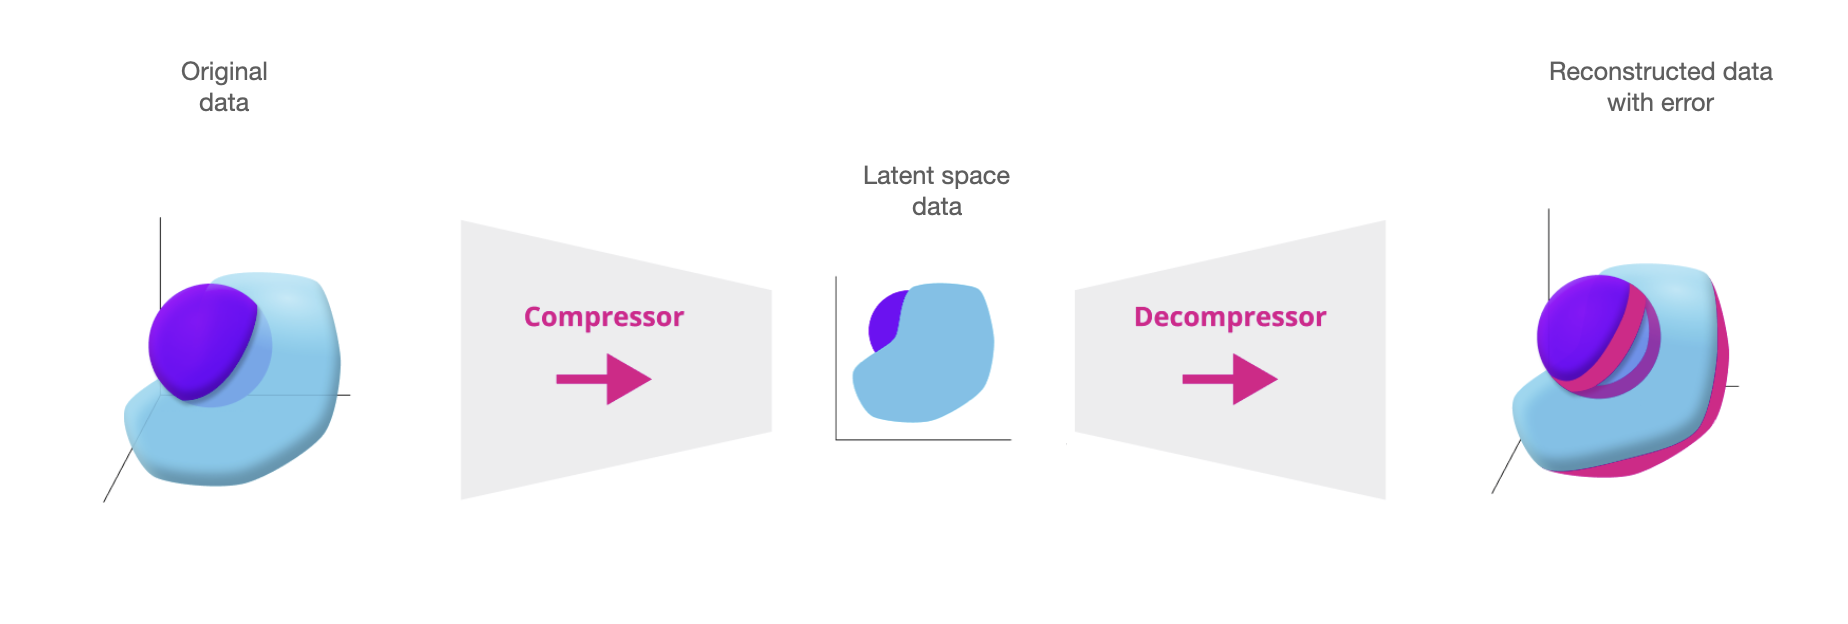

To do this, we use the method `DataReconstructionDriftCalculator` which compresses the **reference feature space** to a latent space using a PCA algorithm. The algorithm later decompresses the latent space data and reconstructs it with some error. This error is called the reconstruction error.

We can later use the learned compressor/decompressor to transform the **production**
set and measure its reconstruction error. If the reconstruction error is bigger than a threshold, the structure learned by PCA no longer accurately resembles the underlying structure of the analysis data. This indicates that there is data drift in the analysis/production data.

To learn more about how this works, check out our documentation [Data Reconstruction with PCA Deep Dive](https://colab.research.google.com/drive/nannyml.readthedocs.io/en/stable/how_it_works/data_reconstruction.html#data-reconstruction-pca).

In [94]:
# Import the required class from NannyML
from nannyml import DataReconstructionDriftCalculator

# Copy the analysis DataFrame to a new DataFrame
analysis_copy = analysis.copy()

# Replace 'actual_churn_data' with your actual DataFrame containing churn values
analysis_copy['churn_actual'] = y_prod

# Get the columns from the reference DataFrame
reference_columns = reference.columns.tolist()

# Create the drift calculator instance using your features
drdc = nml.DataReconstructionDriftCalculator(
    column_names=reference_columns  # Your features list
)

# Fit the model on the reference dataset (test set)
drdc.fit(reference)

# Calculate the multivariate data drift on the analysis dataset (production data)
multivariate_data_drift = drdc.calculate(analysis_copy)

In [95]:
multivariate_data_drift.plot()

Based on the visualized drift score and its relationship with the confidence band and alert threshold, the model's performance in production is likely stable.

We don't see any multivariate drift happening. This may occur because the linear relationships between features did not change much, even though some features may have changed. `DataReconstructionDriftCalculator` is not expected to always capture the drift. We need both multivariate and univariate to have the full picture.

Let's analyze it at a feature level and run the univariate drift detection methods.

### Detecting univariate data drift

Univariate drift detection allows us to perform a more granular investigation. This time we will look at each feature individually and compare the reference and analysis periods in search for drift in any relevant feature.

In [98]:
features = [col for col in data.columns if col not in ['Churn']]

In [99]:
import nannyml as nml

# Define continuous features (replace with your actual continuous feature names)
continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize the Univariate Drift Calculator
udc = nml.UnivariateDriftCalculator(
    column_names=continuous_features
)

# Step 1: Fit the drift calculator on the reference dataset
udc.fit(reference)

# Step 2: Calculate the drift on the analysis dataset using 'wasserstein' as a metric
univariate_data_drift = udc.calculate(analysis, metrics='wasserstein')

In [100]:
for feature in continuous_features:
    drift_result = univariate_data_drift.filter(period='all', metrics='wasserstein', column_names=[feature])

    if not drift_result.empty:  # Check if drift_result is not empty before plotting
        try:
            display(drift_result.plot(kind='distribution', title=f"Wasserstein Drift for {feature}"))
        except Exception as e:
            print(f"Error plotting for feature {feature}: {e}")
    else:
        print(f"No drift result for feature: {feature}")

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kde.py:593: RuntimeWarning:

invalid value encountered in cast



/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kde.py:593: RuntimeWarning:

invalid value encountered in cast



/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kde.py:593: RuntimeWarning:

invalid value encountered in cast



Error plotting for feature TotalCharges: 'float' object is not iterable


### Bonus: Comparing realized and estimated performance

When targets become available, we can calculate the actual model performance on production data. Also called realized performance. In the cell below, we calculate the realized performance and compare it with NannyML's estimation.

In [102]:
import nannyml as nml

# Ensure you have predicted probabilities for the positive class
analysis['y_pred_proba'] = model.predict_proba(analysis[features])[:, 1]  # Get probabilities for the positive class

# Initialize the Performance Calculator
perfc = nml.PerformanceCalculator(
    metrics=['accuracy'],  # Choose the appropriate metrics for your classification task
    y_true='churn_actual',  # Actual churn values in the analysis set
    y_pred='y_pred',  # Predicted churn values
    y_pred_proba='y_pred_proba',  # Predicted probabilities for the positive class
    problem_type='classification_binary',  # Specify binary classification
    timestamp_column_name=None,  # If you don't have a timestamp column, set this to None
    chunk_period=None  # If you don’t need chunking, set this to None
)

# Step 1: Fit the performance calculator on the reference dataset
perfc.fit(reference)

#Step 2: Calculate the realized performance
realized_performance = perfc.calculate(analysis.assign(churn_actual=y_prod))  # Add actual churn values to the analysis dataset

# *** Filter both estimated_performance and realized_performance to a single metric before comparing ***
estimated_performance = estimated_performance.filter(metrics=['accuracy']) # Assuming 'accuracy' is the metric you want to compare
realized_performance = realized_performance.filter(metrics=['accuracy'])

# Step 3: Compare estimated performance with realized performance and plot the results
estimated_performance.filter(period='analysis').compare(realized_performance).plot().show()

We can observe that the estimates align closely with the actual results, particularly for the accuracy metric. This confirms the reliability of CBPE in monitoring model performance on unseen data, enabling early detection of potential performance degradation.



## Conclusion

We developed an ML model to predict customer churn based on various factors related to customer behavior and service usage. Following the model's deployment, we utilized NannyML's performance estimation tools to identify and analyze potential performance degradation in our predictions. By implementing data drift detection methods, we were able to pinpoint the specific causes behind these performance issues.

Having identified the root causes of the churn model's performance degradation, our next step is to explore effective solutions to mitigate these challenges. To learn more about actionable strategies for improving model performance amidst changing data distributions, refer to this blog post to learn six ways
 [to address data distribution shift](https://www.nannyml.com/blog/6-ways-to-address-data-distribution-shift).